In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
%load_ext rpy2.ipython
%R library(ggplot2)

R[write to console]: Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang



array(['ggplot2', 'tools', 'stats', 'graphics', 'grDevices', 'utils',
       'datasets', 'methods', 'base'], dtype='<U9')

In [3]:
df = pd.read_csv('../data/historical/Batting.csv')
games = pd.read_csv('../data/historical/Teams.csv')

In [4]:
# revenue dataframe
revenue = {1990: 1.3461, 1991: 1.4591, 1992: 1.5836, 1993: 1.7745, 1994: 1.6870, 
           1995: 1.4105, 1996: 1.8472, 1997: 2.2158, 1998: 2.6633, 1999: 2.8279, 2000: 3.1776, 2001: 3.5830, 
           2002: 3.65, 2003: 3.878, 2004 : 4.27
            }
rev = pd.DataFrame.from_dict(revenue, orient='index', columns = ['Revenue'])
rev.index.name = 'yearID'
rev = rev.reset_index()

In [5]:
games = games[['yearID', 'teamID', 'G']]

In [6]:
# group games by year and sum how many games
game_gr = games.groupby('yearID').sum().reset_index()
# restrict games to only steroid era
game_gr = game_gr.loc[(game_gr.yearID > 1989) & (game_gr.yearID < 2005)]

In [7]:
# group batting dataframe and restrict to steroid era
gr = df.groupby('yearID').sum().reset_index().drop('G', axis = 1)
gr = gr.loc[(gr.yearID > 1989) & (gr.yearID < 2005)]

In [8]:
# join batting and games to get proper game sum
era = pd.merge(gr, game_gr, on = 'yearID', how = 'left')
# create steroid flag column
era['steroidFlag'] = np.where(era.yearID < 1993, 'no', 'yes')
# create home runs per game column
era['hr_G'] = era.HR / era.G

In [9]:
# join era data frame with revenue data
join = pd.merge(era, rev, on = 'yearID', how = 'left')

In [10]:
%R -i join

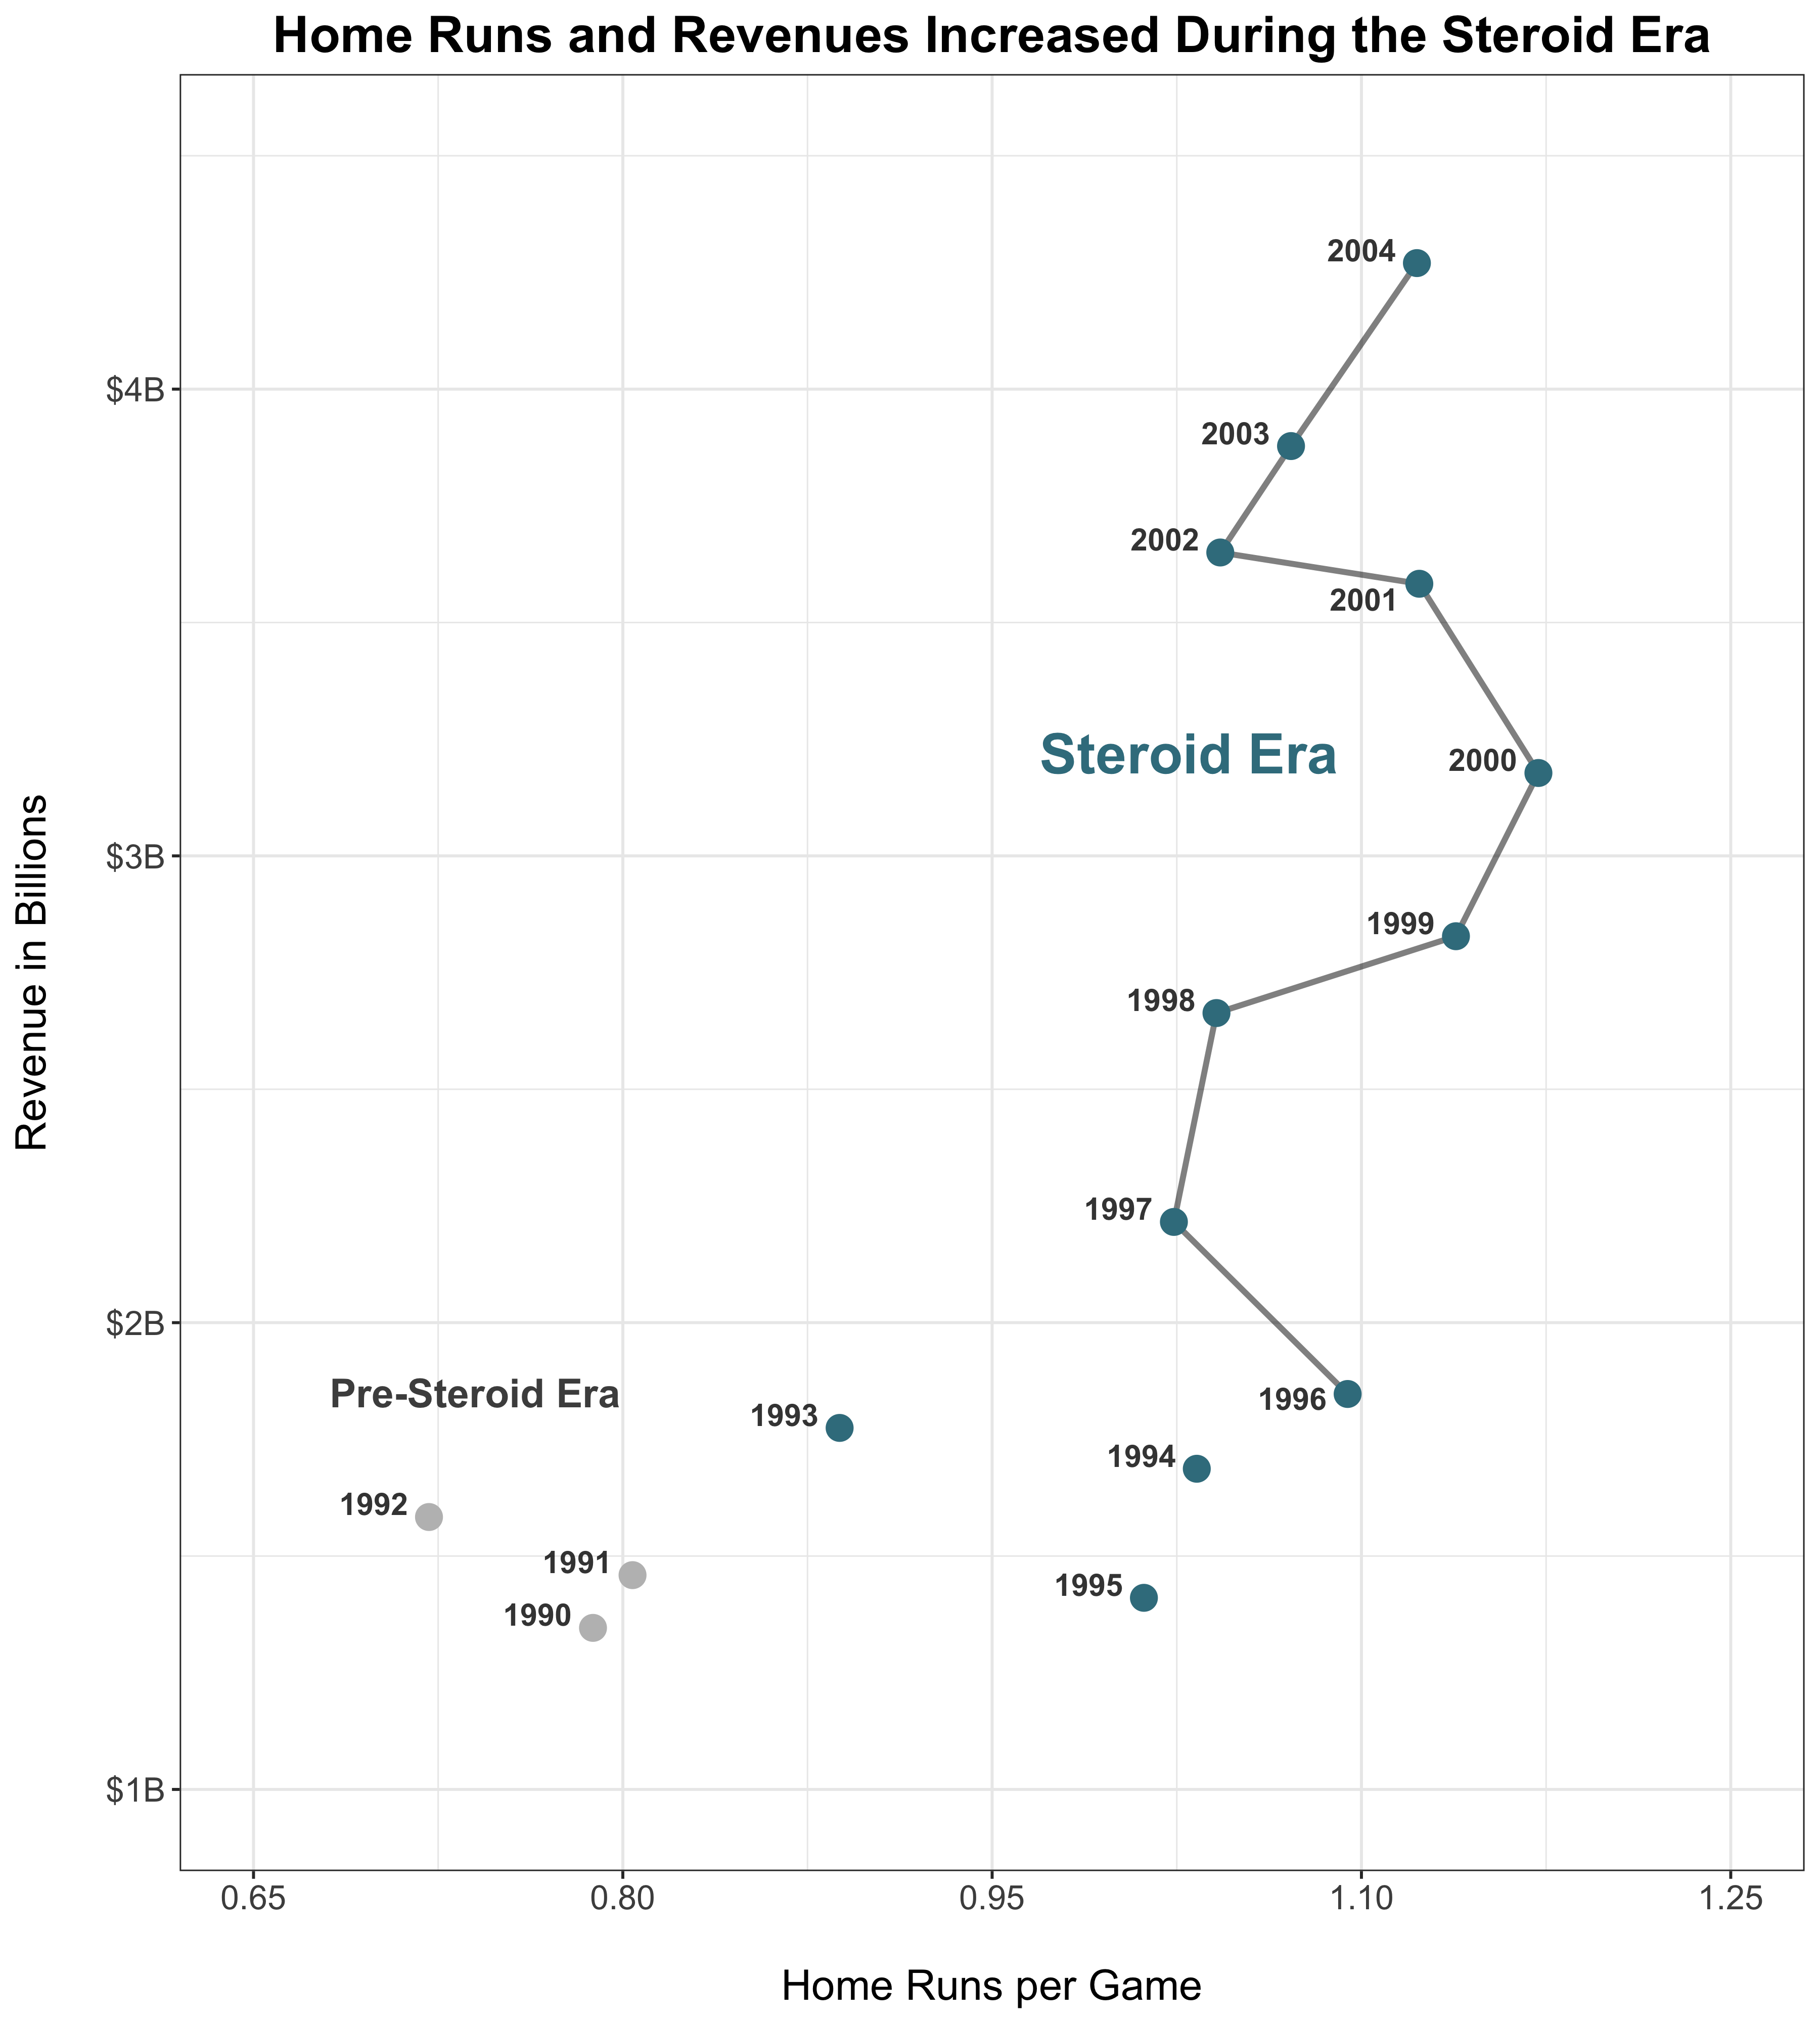

In [11]:
%%R -w 9 -h 10 --units in -r 400

ggplot() + 
    geom_segment(aes(x = 1.094398, xend = 1.023831, y = 1.8472, yend = 2.2158), size = 1, alpha = 0.5) +
    geom_segment(aes(x = 1.023831, xend = 1.041118, y = 2.2158, yend = 2.6633), size = 1, alpha = 0.5) +
    geom_segment(aes(x = 1.041118, xend = 1.138386, y = 2.6633, yend = 2.8279), size = 1, alpha = 0.5) +
    geom_segment(aes(x = 1.138386, xend = 1.171881, y = 2.8279, yend = 3.1776), size = 1, alpha = 0.5) +
    geom_segment(aes(x = 1.171881, xend = 1.123508, y = 3.1776, yend = 3.5830), size = 1, alpha = 0.5) +
    geom_segment(aes(x = 1.123508, xend = 1.042663, y = 3.5830, yend = 3.6500), size = 1, alpha = 0.5) +
    geom_segment(aes(x = 1.042663, xend = 1.071399, y = 3.6500, yend = 3.8780), size = 1, alpha = 0.5) +
    geom_segment(aes(x = 1.071399, xend = 1.122529, y = 3.8780, yend = 4.2700), size = 1, alpha = 0.5) +
    annotate("text", x = 0.74, y = 1.85, size = 5, color = 'gray30',
                label = "Pre-Steroid Era", fontface = 'bold') +
    annotate("text", x = 1.03, y = 3.22, size = 7, color = '#3b7d8d',
                label = "Steroid Era", fontface = 'bold') +
    geom_point(aes(x = hr_G, y = Revenue, color = steroidFlag), size = 4, data = join) +
    geom_text(aes(x = hr_G, y = Revenue, label = yearID), fontface = 'bold', alpha = 0.8, data = join, hjust = 1.3, 
              vjust = ifelse(join$yearID == 2001, 1.2, ifelse(join$yearID == 1996, 0.7, -0.1))) +
    scale_color_manual(values = c('gray', '#3b7d8d')) +
    scale_x_continuous(limits = c(0.65, 1.25), breaks = seq(0.65, 1.25, by = 0.15)) +
    scale_y_continuous(limits = c(1, 4.5), breaks = seq(1, 4.5, by = 1), 
                       labels = scales::dollar_format(suffix = "B")) +
    theme_bw() + 
    ggtitle('Home Runs and Revenues Increased During the Steroid Era') +
    xlab('\nHome Runs per Game') +
    ylab('Revenue in Billions\n') +
    guides(color = F) +
    theme(text = element_text(size = 15), plot.title = element_text(hjust = 0.5, face = 'bold'))

In [12]:
%R ggsave('../images/era.pdf', units = 'in', width = 10, height = 9, dpi = 400)